In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv


In [2]:
import numpy as np 
import pandas as pd 
import warnings

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

warnings.filterwarnings("ignore")

/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/sample_submission.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv
/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv


In [3]:
train_data = pd.read_csv("/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/train.csv")
eval_data = pd.read_csv("/kaggle/input/mlp-term-2-2025-kaggle-assignment-3/test.csv")

In [4]:
train_data.shape, eval_data.shape
train_data.head()
train_data.columns

Index(['id', 'store_name', 'category', 'store_address', 'latitude ',
       'longitude', 'rating_count', 'review_time', 'review', 'rating'],
      dtype='object')

In [5]:
train_data = train_data.rename(columns={"latitude ": "latitude"})

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26500 entries, 0 to 26499
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             26500 non-null  int64  
 1   store_name     26500 non-null  object 
 2   category       26500 non-null  object 
 3   store_address  26500 non-null  object 
 4   latitude       25976 non-null  float64
 5   longitude      25976 non-null  float64
 6   rating_count   26500 non-null  object 
 7   review_time    26500 non-null  object 
 8   review         26500 non-null  object 
 9   rating         26500 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 2.0+ MB


In [7]:
train_data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,26500.0,13249.500000,7650.035403,0.000000,6624.750000,13249.500000,19874.250000,26499.00000
latitude,25976.0,34.427152,5.336112,25.790295,28.655350,33.931261,40.727401,44.98141
longitude,25976.0,-90.659226,16.588603,-121.995421,-97.792874,-81.471414,-75.399919,-73.45982
rating,26500.0,3.130642,1.615425,1.000000,1.000000,3.000000,5.000000,5.00000


In [8]:
train_data.drop("id", axis=1, inplace=True)
eval_data.drop("id", axis=1, inplace=True)

In [9]:
train_data.duplicated().value_counts()

train_data = train_data[train_data.duplicated() == False]
train_data.duplicated().value_counts()

False    23198
Name: count, dtype: int64

In [10]:
train_data.reset_index(inplace=True, drop=True) 

train_data.shape

(23198, 9)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

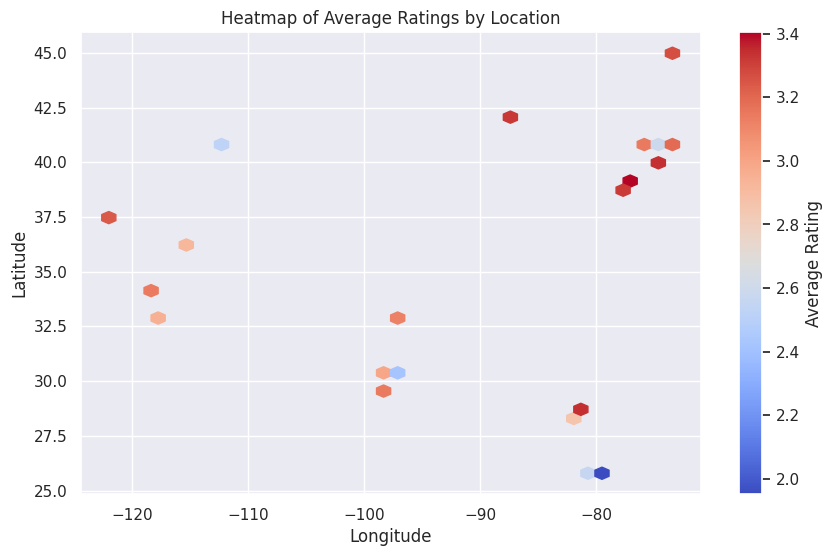

In [12]:
plt.figure(figsize=(10,6))
hb = plt.hexbin(train_data["longitude"], train_data["latitude"], 
                C=train_data["rating"], gridsize=40, cmap="coolwarm", reduce_C_function=np.mean)

plt.colorbar(hb, label="Average Rating")
plt.title("Heatmap of Average Ratings by Location")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

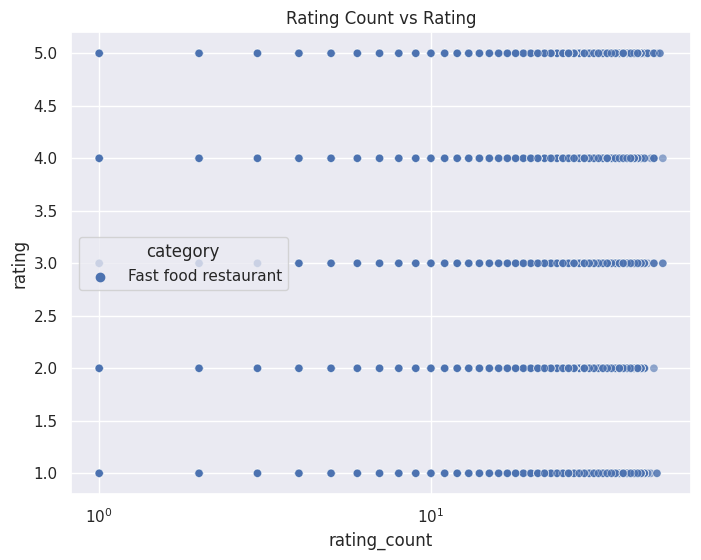

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(x="rating_count", y="rating", hue="category", data=train_data, alpha=0.6)
plt.title("Rating Count vs Rating")
plt.xscale("log")  # log scale for better visibility
plt.show()

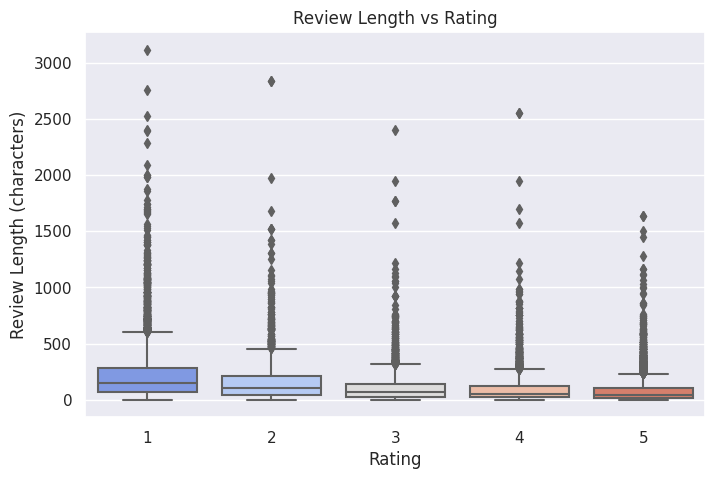

In [14]:
train_data["review_length"] = train_data["review"].astype(str).apply(len)

plt.figure(figsize=(8,5))
sns.boxplot(x="rating", y="review_length", data=train_data, palette="coolwarm")
plt.title("Review Length vs Rating")
plt.xlabel("Rating")
plt.ylabel("Review Length (characters)")
plt.show()

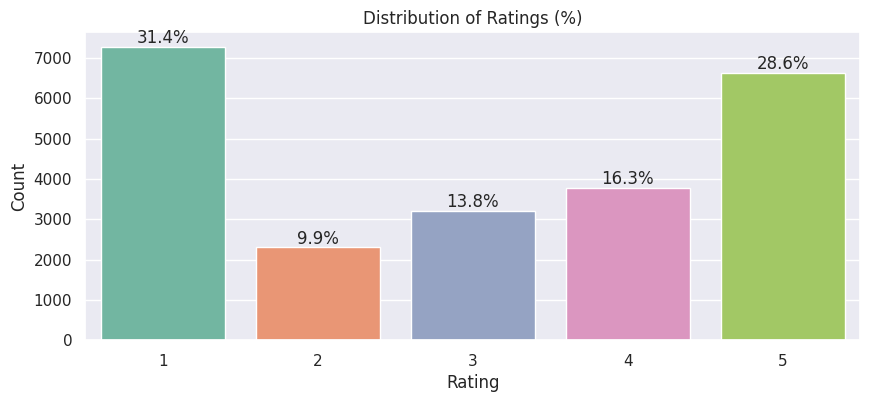

In [15]:
plt.figure(figsize=(10,4))
ax = sns.countplot(x="rating", data=train_data, palette="Set2")

total = len(train_data)
for p in ax.patches:
    percentage = f'{100 * p.get_height()/total:.1f}%'
    ax.annotate(percentage, (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom')

plt.title("Distribution of Ratings (%)")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [16]:
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

train_data.drop("review_length", axis=1, inplace=True)

train_data.isna().sum()



store_name         0
category           0
store_address      0
latitude         524
longitude        524
rating_count       0
review_time        0
review             0
rating             0
dtype: int64

In [17]:
train_data["rating_count"] = (
    train_data["rating_count"]
    .astype(str)
    .str.replace(",", "", regex=True)
    .astype(float)
)

eval_data["rating_count"] = (
    eval_data["rating_count"]
    .astype(str)
    .str.replace(",", "", regex=True)
    .astype(float)
)

In [18]:
X = train_data.drop("rating", axis=1)
y = train_data["rating"]


numeric_features = ["rating_count", "latitude", "longitude"] 
categorical_features = ["store_name", "store_address", "review_time", "review"]

numeric_imputer = SimpleImputer(strategy="median")
categorical_imputer = SimpleImputer(strategy="most_frequent")


imputer = ColumnTransformer(
    transformers=[
        ("num", numeric_imputer, numeric_features),
        ("cat", categorical_imputer, categorical_features)
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
).set_output(transform="pandas")

In [19]:
X = imputer.fit_transform(X)
eval_data = imputer.transform(eval_data)

In [20]:
def remove_outliers_iqr(X, y, cols):
    cleaned_X = X.copy()
    cleaned_y = y.copy()
    for col in cols:
        Q1 = cleaned_X[col].quantile(0.25)
        Q3 = cleaned_X[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        cleaned_X, cleaned_y = cleaned_X[(cleaned_X[col] >= lower) & (cleaned_X[col] <= upper)], cleaned_y[(cleaned_X[col] >= lower) & (cleaned_X[col] <= upper)]
    return cleaned_X, cleaned_y

X_clean, y_clean = remove_outliers_iqr(X, y, numeric_features)

print("Training data Before:", X.shape)
print("Training data After:", X_clean.shape)
print("Target data Before:", y.shape)
print("Target data After:", y_clean.shape)

Training data Before: (23198, 8)
Training data After: (22803, 8)
Target data Before: (23198,)
Target data After: (22803,)


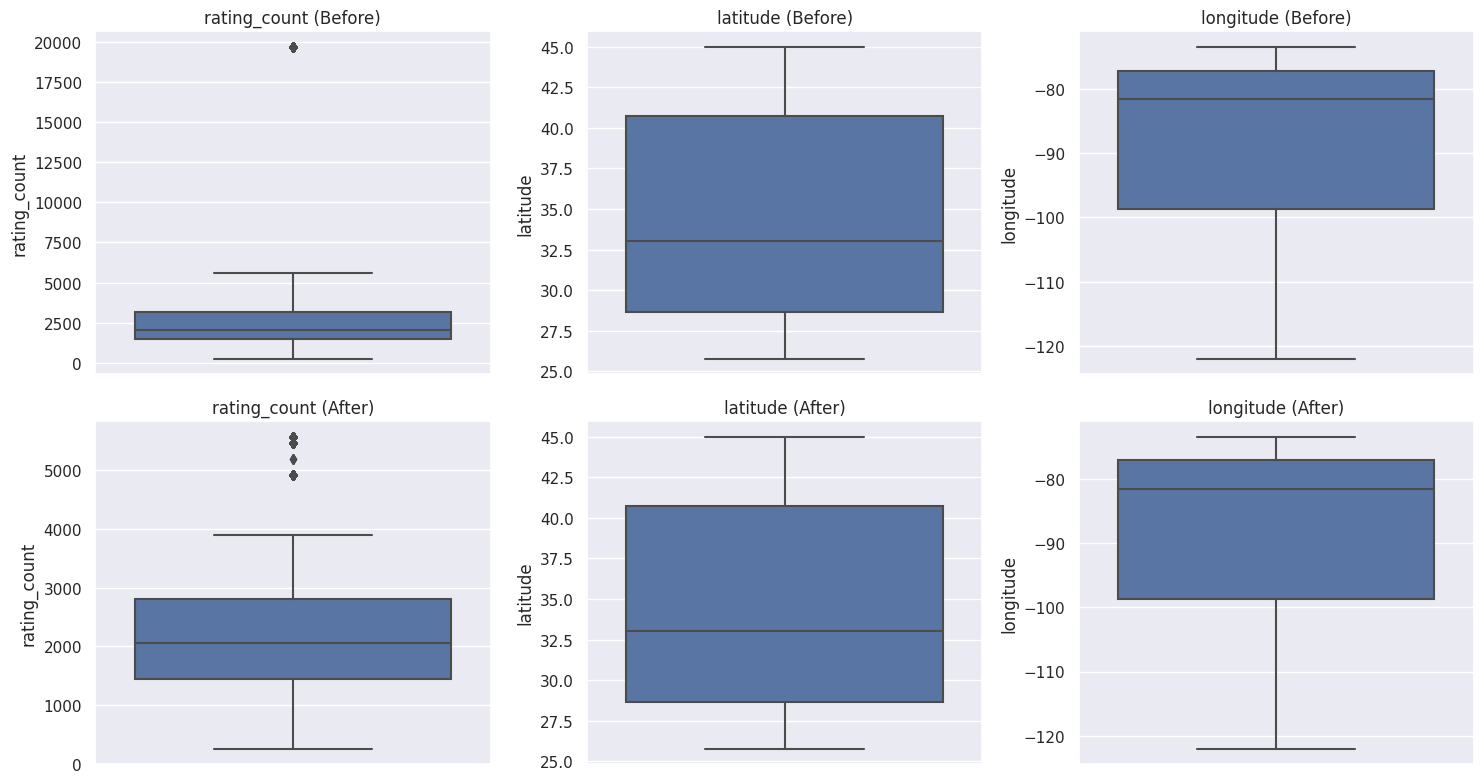

In [21]:
plt.figure(figsize=(15,8))

for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, len(numeric_features), i)
    sns.boxplot(y=X[col])
    plt.title(f"{col} (Before)")
    
    plt.subplot(2, len(numeric_features), i + len(numeric_features))
    sns.boxplot(y=X_clean[col])
    plt.title(f"{col} (After)")

plt.tight_layout()
plt.show()

In [22]:
summary = {}
for col in numeric_features:
    Q1, Q3 = X[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    outliers = X[(X[col] < lower) | (X[col] > upper)]
    summary[col] = len(outliers)

pd.DataFrame(summary, index=["Outliers Removed"]).T

,Outliers Removed
rating_count,395
latitude,0
longitude,0


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

X_clean.drop(["category", "store_address"], axis=1, inplace=True)
eval_data.drop(["category", "store_address"], axis=1, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=42)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

X_train shape: (18242, 6)
X_test shape: (4561, 6)


In [24]:
X_train.sample(5)

# Feature Engineering Function for Latitude & Longitude

def geo_features(df):
    lat_center, lon_center = 39.8283, -98.5795
    df = df.copy()
    df["distance_from_center"] = np.sqrt((df["latitude"] - lat_center)**2 + 
                                         (df["longitude"] - lon_center)**2)
    return df[["distance_from_center"]]


# Review Time Conversion

def parse_review_time(series):
    return series.str.extract(r"(\d+)").astype(float).fillna(1.0)  # "a year ago" → 1

In [25]:
numeric_minmax = ["rating_count"] 
geo_features_cols = ["latitude", "longitude"]
time_features = "review_time" 
categorical_features = ["store_name"]
text_features = "review" 

In [26]:
minmax_transformer = Pipeline([
    ("scaler", MinMaxScaler())
])

geo_transformer = Pipeline([
    ("geo", FunctionTransformer(geo_features, validate=False)),
    ("scaler", StandardScaler()) 
])

time_transformer = Pipeline([
    ("extract_years", FunctionTransformer(parse_review_time, validate=False)),
    ("scaler", StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

text_transformer = Pipeline([
    ("tfidf", TfidfVectorizer(stop_words="english", lowercase=True, max_df=0.8, min_df=5))
])

In [27]:
preprocessor = ColumnTransformer(
    transformers=[
        ("minmax", minmax_transformer, numeric_minmax),
        ("geo", geo_transformer, geo_features_cols),
        ("time", time_transformer, time_features),
        ("cat", categorical_transformer, categorical_features),
        ("text", text_transformer, text_features)
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

In [28]:
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)
eval_data = preprocessor.transform(eval_data)

X_train = pd.DataFrame(X_train.toarray())
X_test = pd.DataFrame(X_test.toarray())
eval_data = pd.DataFrame(eval_data.toarray())

X_train.sample(5)

,0,1,2,3,4,5,6,7,8,9,...,3250,3251,3252,3253,3254,3255,3256,3257,3258,3259
6311,0.244910,0.797411,-0.361678,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
8830,0.561840,-0.972276,3.239700,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
16573,0.980958,0.281110,-1.262022,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
13496,0.451546,-2.022625,0.088495,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0
1385,0.479827,0.724664,-0.361678,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.95917,0.0,0.0,0.0


In [29]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, accuracy_score

In [30]:
def model_building(X_train, X_test, y_train, y_test, model):

    model.fit(X_train, y_train)
    train_score = accuracy_score(model.predict(X_train), y_train)
    test_score = accuracy_score(model.predict(X_test), y_test)

    return (train_score, test_score)


log = LogisticRegression(max_iter=500, random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42)
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
sgd = SGDClassifier(early_stopping=True,loss="log_loss", max_iter=500, tol=1e-3, random_state=42)
gb = GradientBoostingClassifier(random_state=42)

In [31]:
models = {
    "LogisticRegression": log,
    "DecisionTree": dt,
    "RandomForest": rf,
    "MLP": mlp,
    "AdaBoost": ada,
    "SGD": sgd,
    "GradientBoosting": gb
}# score = {}
# preds = {}

# for model in models:
#     score[model] = model_building(X_train, X_test, y_train, y_test, models[model])
#     preds[model] = models[model].predict(X_test)
#     print(f"Classification report of {model}:")
#     print(classification_report(y_test, preds[model]), "\n")

# np.set_printoptions(threshold=np.inf)

In [32]:
class_reports = {
    'LogisticRegression': '              precision    recall  f1-score   support\n\n           1       0.67      0.89      0.76      1483\n           2       0.40      0.11      0.17       454\n           3       0.43      0.33      0.37       601\n           4       0.46      0.28      0.35       734\n           5       0.63      0.75      0.69      1289\n\n    accuracy                           0.60      4561\n   macro avg       0.52      0.47      0.47      4561\nweighted avg       0.57      0.60      0.56      4561\n',
    'DecisionTree': '              precision    recall  f1-score   support\n\n           1       0.71      0.75      0.73      1483\n           2       0.40      0.35      0.37       454\n           3       0.39      0.36      0.38       601\n           4       0.39      0.37      0.38       734\n           5       0.61      0.63      0.62      1289\n\n    accuracy                           0.57      4561\n   macro avg       0.50      0.49      0.50      4561\nweighted avg       0.56      0.57      0.56      4561\n',
    'RandomForest': '              precision    recall  f1-score   support\n\n           1       0.67      0.90      0.77      1483\n           2       0.84      0.27      0.41       454\n           3       0.59      0.33      0.42       601\n           4       0.54      0.28      0.37       734\n           5       0.61      0.81      0.70      1289\n\n    accuracy                           0.64      4561\n   macro avg       0.65      0.52      0.53      4561\nweighted avg       0.64      0.64      0.60      4561\n',
    'MLP': '              precision    recall  f1-score   support\n\n           1       0.74      0.76      0.75      1483\n           2       0.40      0.35      0.37       454\n           3       0.43      0.41      0.42       601\n           4       0.42      0.43      0.43       734\n           5       0.66      0.67      0.67      1289\n\n    accuracy                           0.60      4561\n   macro avg       0.53      0.53      0.53      4561\nweighted avg       0.59      0.60      0.59      4561\n',
    'AdaBoost': '              precision    recall  f1-score   support\n\n           1       0.56      0.90      0.69      1483\n           2       0.47      0.10      0.17       454\n           3       0.37      0.20      0.26       601\n           4       0.35      0.24      0.28       734\n           5       0.62      0.61      0.62      1289\n\n    accuracy                           0.54      4561\n   macro avg       0.47      0.41      0.40      4561\nweighted avg       0.51      0.54      0.50      4561\n',
    'SGD': '              precision    recall  f1-score   support\n\n           1       0.61      0.93      0.74      1483\n           2       0.56      0.08      0.14       454\n           3       0.54      0.18      0.27       601\n           4       0.42      0.22      0.29       734\n           5       0.61      0.76      0.68      1289\n\n    accuracy                           0.59      4561\n   macro avg       0.55      0.44      0.42      4561\nweighted avg       0.56      0.59      0.53      4561\n',
    'GradientBoosting': '              precision    recall  f1-score   support\n\n           1       0.56      0.92      0.70      1483\n           2       0.51      0.09      0.15       454\n           3       0.49      0.19      0.28       601\n           4       0.45      0.16      0.23       734\n           5       0.59      0.72      0.65      1289\n\n    accuracy                           0.56      4561\n   macro avg       0.52      0.41      0.40      4561\nweighted avg       0.54      0.56      0.50      4561\n'
}

In [33]:
acc_scores = {
    'LogisticRegression': (0.6829843218945291, 0.6027187020390266),
    'DecisionTree': (0.9899682052406534, 0.5650076737557553),
    'RandomForest': (0.9899682052406534, 0.6371409778557334),
    'MLP': (0.962942659796075, 0.595483446612585),
    'AdaBoost': (0.5495559697401601, 0.5393554045165534),
    'SGD': (0.6216971823264993, 0.5875904406928305),
    'GradientBoosting': (0.6150641377041991, 0.5608419206314404)
}

In [34]:
for model in class_reports:
    print(f"Classification report of {model} classifier is:")
    print(class_reports[model])
    print(f"Accuracy score:")
    print(f"Test: {acc_scores[model][1]}, Train: {acc_scores[model][0]} \n\n")

Classification report of LogisticRegression classifier is:
              precision    recall  f1-score   support

           1       0.67      0.89      0.76      1483
           2       0.40      0.11      0.17       454
           3       0.43      0.33      0.37       601
           4       0.46      0.28      0.35       734
           5       0.63      0.75      0.69      1289

    accuracy                           0.60      4561
   macro avg       0.52      0.47      0.47      4561
weighted avg       0.57      0.60      0.56      4561

Accuracy score:
Test: 0.6027187020390266, Train: 0.6829843218945291 


Classification report of DecisionTree classifier is:
              precision    recall  f1-score   support

           1       0.71      0.75      0.73      1483
           2       0.40      0.35      0.37       454
           3       0.39      0.36      0.38       601
           4       0.39      0.37      0.38       734
           5       0.61      0.63      0.62      1289

  

In [35]:
from sklearn.model_selection import RandomizedSearchCV

def tuning(model, param_dist, X_train, y_train):
    rscv = RandomizedSearchCV(model, param_dist, n_iter=5, cv=5, scoring='accuracy', verbose=1, random_state=42, n_jobs=-1)
    rscv.fit(X_train, y_train)
    return rscv.best_estimator_, rscv.best_params_




In [36]:
from scipy.stats import randint, uniform

param_dists = {
    "DecisionTree": {
        "max_depth": randint(3, 20),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 20),
        "criterion": ["gini", "entropy", "log_loss"]
    },
    "RandomForest": {
        "n_estimators": randint(100, 1000),
        "max_depth": [None] + list(range(5, 50, 5)),
        "min_samples_split": randint(2, 20),
        "min_samples_leaf": randint(1, 20),
        "max_features": ["sqrt", "log2", None],
        "bootstrap": [True, False]
    },
    "MLP": {
        "hidden_layer_sizes": [(50,), (100,), (100,50), (150,100,50)],
        "activation": ["tanh", "relu", "logistic"],
        "solver": ["adam", "sgd"],
        "alpha": uniform(0.0001, 0.1), 
        "learning_rate": ["constant", "adaptive"],
        "max_iter": [200, 300, 500]
    },
    "AdaBoost": {
        "n_estimators": randint(50, 500),
        "learning_rate": uniform(0.01, 1.0),
        "algorithm": ["SAMME", "SAMME.R"]
    }
}

In [37]:
estimators = {
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(random_state=42),
    "MLP": MLPClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

In [38]:
best_acc_scores = {
    "DecisionTree": 0.5101951326463495,
    "MLP": 0.6005262003946503
}

In [39]:
best_params = {
    "DecisionTree": {
        'criterion': 'log_loss',
        'max_depth': 17,
        'min_samples_leaf': 11,
        'min_samples_split': 9
    },
    'MLP': {
        'activation': 'logistic',
        'alpha': 0.0797542986860233,
        'hidden_layer_sizes': (100, 50),
        'learning_rate': 'constant',
        'max_iter': 200,
        'solver': 'adam'
    }
}

In [40]:
best_class_reports = {
    "DecisionTree": '              precision    recall  f1-score   support\n\n           1       0.47      0.95      0.63      1483\n           2       0.53      0.06      0.10       454\n           3       0.52      0.08      0.15       601\n           4       0.44      0.22      0.29       734\n           5       0.63      0.53      0.58      1289\n\n    accuracy                           0.51      4561\n   macro avg       0.52      0.37      0.35      4561\nweighted avg       0.52      0.51      0.44      4561\n',
    "RandomForest": RandomForestClassifier(random_state=42),
    "MLP": '              precision    recall  f1-score   support\n\n           1       0.70      0.87      0.77      1483\n           2       0.49      0.10      0.17       454\n           3       0.39      0.38      0.38       601\n           4       0.41      0.20      0.27       734\n           5       0.62      0.80      0.70      1289\n\n    accuracy                           0.60      4561\n   macro avg       0.52      0.47      0.46      4561\nweighted avg       0.57      0.60      0.56      4561\n',
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

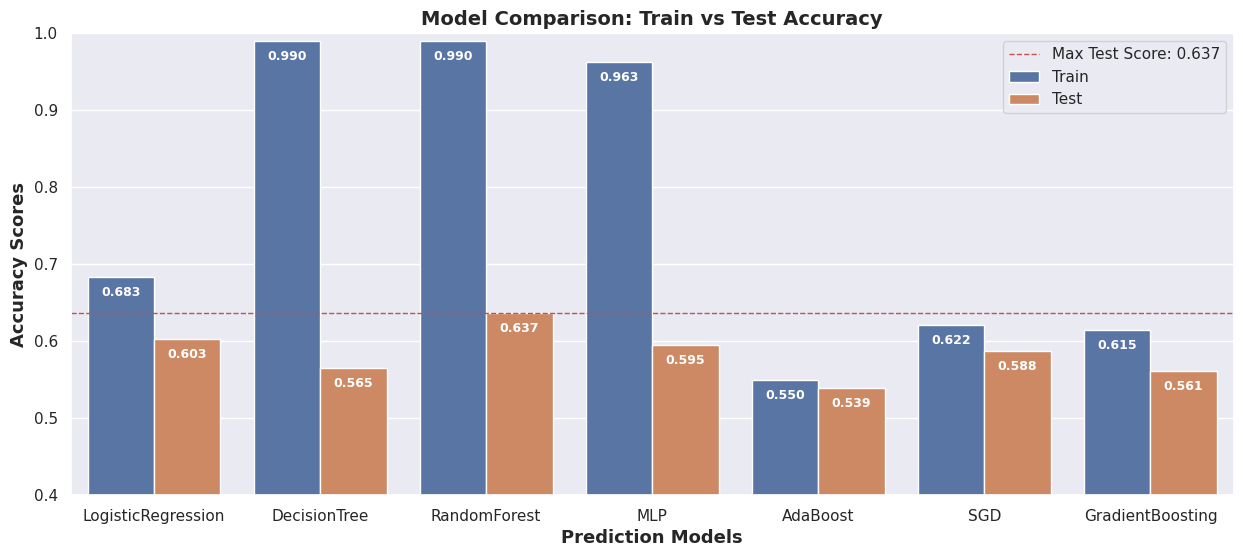

In [41]:
data = []
for model, scores in acc_scores.items():
    data.append({"Model": model, "Score": scores[0], "Type": "Train"})
    data.append({"Model": model, "Score": scores[1], "Type": "Test"})

df = pd.DataFrame(data)

# Plot side-by-side bars
plt.figure(figsize=(15, 6))
ax = sns.barplot(data=df, x="Model", y="Score", hue="Type")

# Add max score line (for test scores)
max_score = df[df["Type"] == "Test"]["Score"].max()
plt.axhline(y=max_score, color="r", linestyle="--", linewidth=1,
            label=f'Max Test Score: {max_score:.3f}')

# Formatting
plt.ylim(0.4, 1.0)
plt.xlabel("Prediction Models", fontweight="bold", fontsize=13)
plt.ylabel("Accuracy Scores", fontweight="bold", fontsize=13)
plt.title("Model Comparison: Train vs Test Accuracy", fontweight="bold", fontsize=14)
plt.legend()

# Annotate scores
for p in ax.patches:
    ax.annotate(f'{p.get_height():.3f}',
                (p.get_x() + p.get_width() / 2., p.get_height() - 0.02),
                ha='center', va='center', fontsize=9, color='white', weight='bold')

plt.show()

In [42]:
best_model = RandomForestClassifier(n_estimators=100, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(eval_data)

submission = pd.DataFrame()

submission["id"] = np.arange(0, y_pred.shape[0])
submission["rating"] = y_pred


submission.to_csv("submission.csv",index=False)

